In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import rbcde

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/usr/local/lib/python3.6/dist-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5 anndata==0.7rc1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

Import some demonstration data - 10x PBMCs, annotated as part of the Scanpy tutorial.

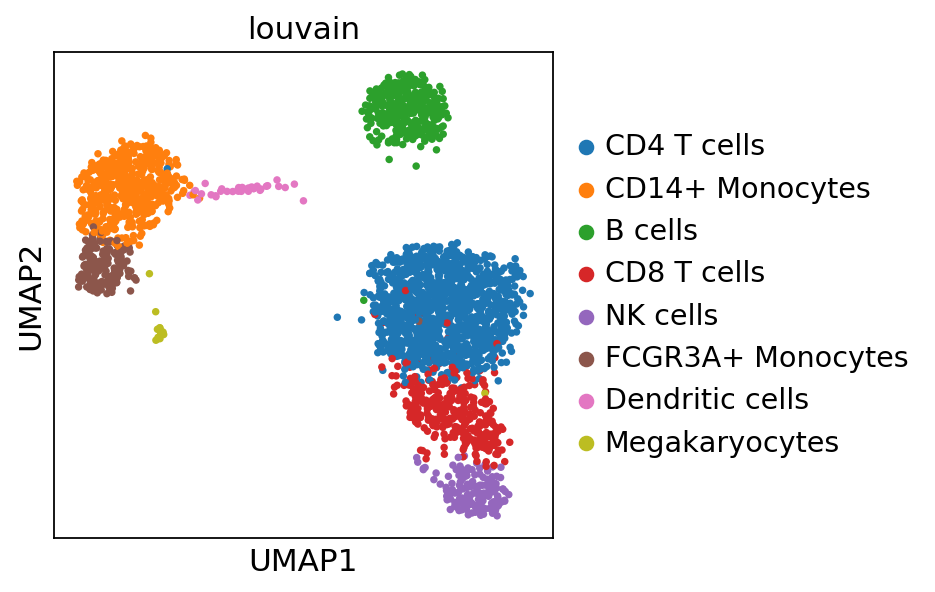

In [3]:
adata = sc.datasets.pbmc3k_processed()
sc.pl.umap(adata, color='louvain')

Compute the rank-biserial correlation for each of the genes in each of the clusters. Use the `.raw` form of data, as that's where this object stores `log(CPM/100 + 1)`. The rank-biserial correlation coefficients are stored in the corresponding `.var` (if not using `.raw`, instead having the appropriately transformed data in `.X` or a `.layers` field, the results would be stored in `.var`).

In [4]:
rbcde.RBC(adata, clus_key='louvain', use_raw=True)
adata.raw.var.head()

computing rank-biserial correlation
	finished: added
	'RBC_' columns for each of the clusters to .raw.var (0:00:08)


,n_cells,RBC_B cells,RBC_CD14+ Monocytes,RBC_CD4 T cells,RBC_CD8 T cells,RBC_Dendritic cells,RBC_FCGR3A+ Monocytes,RBC_Megakaryocytes,RBC_NK cells
index,,,,,,,,,
AL627309.1,9,-0.003920,0.011110,-0.002937,-0.000281,-0.003460,-0.003617,-0.003431,-0.003623
AP006222.2,3,-0.001307,0.001157,-0.000465,0.002303,-0.001153,-0.001206,-0.001144,-0.001208
RP11-206L10.2,5,0.004541,-0.002317,-0.001803,-0.002153,0.052901,-0.002010,-0.001906,-0.002013
RP11-206L10.9,3,-0.001307,0.006250,-0.002008,-0.001292,-0.001153,-0.001206,-0.001144,-0.001208
LINC00115,18,0.002239,0.004393,-0.004331,-0.000561,-0.006920,-0.000166,-0.006862,0.006546


Identify actual marker genes for the clusters by thresholding the coefficient. Literature [critical values](https://en.wikipedia.org/wiki/Effect_size#Pearson_r_or_correlation_coefficient) can be used as cutoffs - 0.5 is considered to be a large effect.

In [5]:
degs, plot_dict = rbcde.filter_markers(adata, thresh=0.5, use_raw=True)
degs

--> 15 markers found for cluster B cells
--> 50 markers found for cluster CD14+ Monocytes
--> 22 markers found for cluster CD4 T cells
--> 7 markers found for cluster CD8 T cells
--> 218 markers found for cluster Dendritic cells
--> 158 markers found for cluster FCGR3A+ Monocytes
--> 72 markers found for cluster Megakaryocytes
--> 28 markers found for cluster NK cells


,cluster,RBC
CD79A,B cells,0.925758
CD74,B cells,0.902726
CD79B,B cells,0.864269
HLA-DRA,B cells,0.839000
MS4A1,B cells,0.835537
...,...,...
UBB,NK cells,0.534452
XCL2,NK cells,0.526892
ITGB2,NK cells,0.520573
KLRD1,NK cells,0.520568


Plot the identified markers for each of the clusters. Limiting to top 50 for plot clarity. Markers consulted with biologist, who deemed them comparable in quality to the output of established marker detection algorithms and suitable for reproducing the annotation.

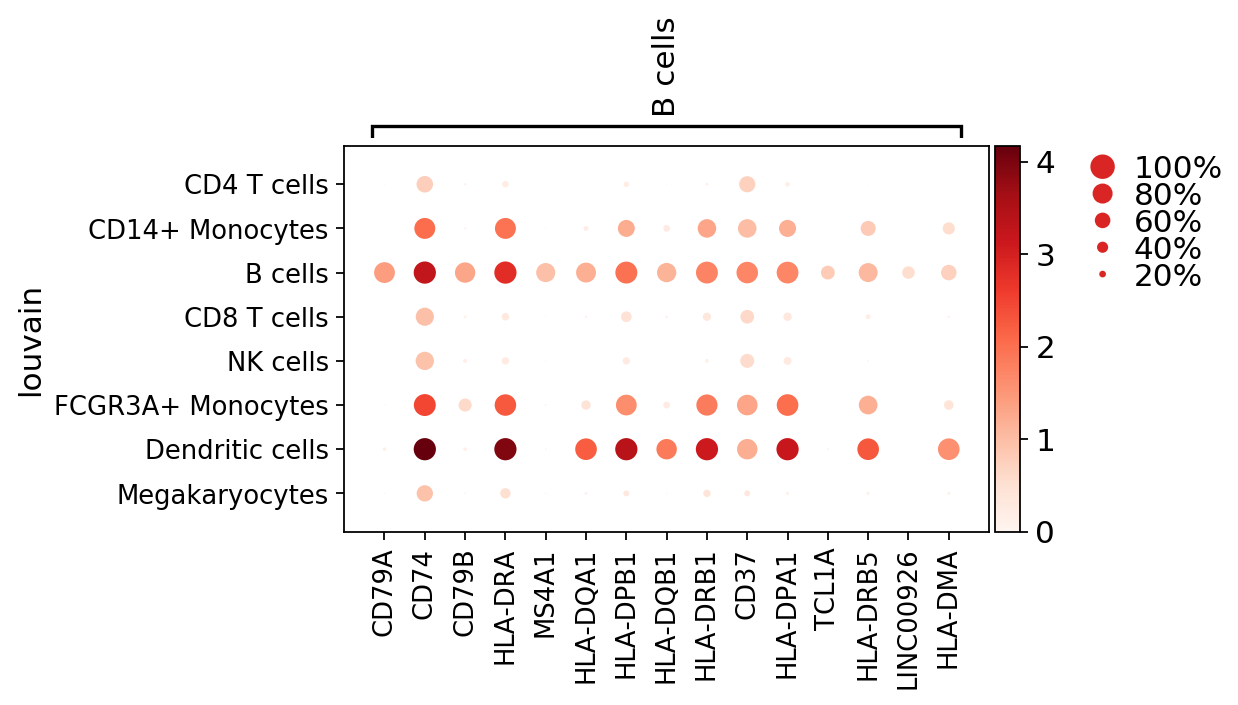

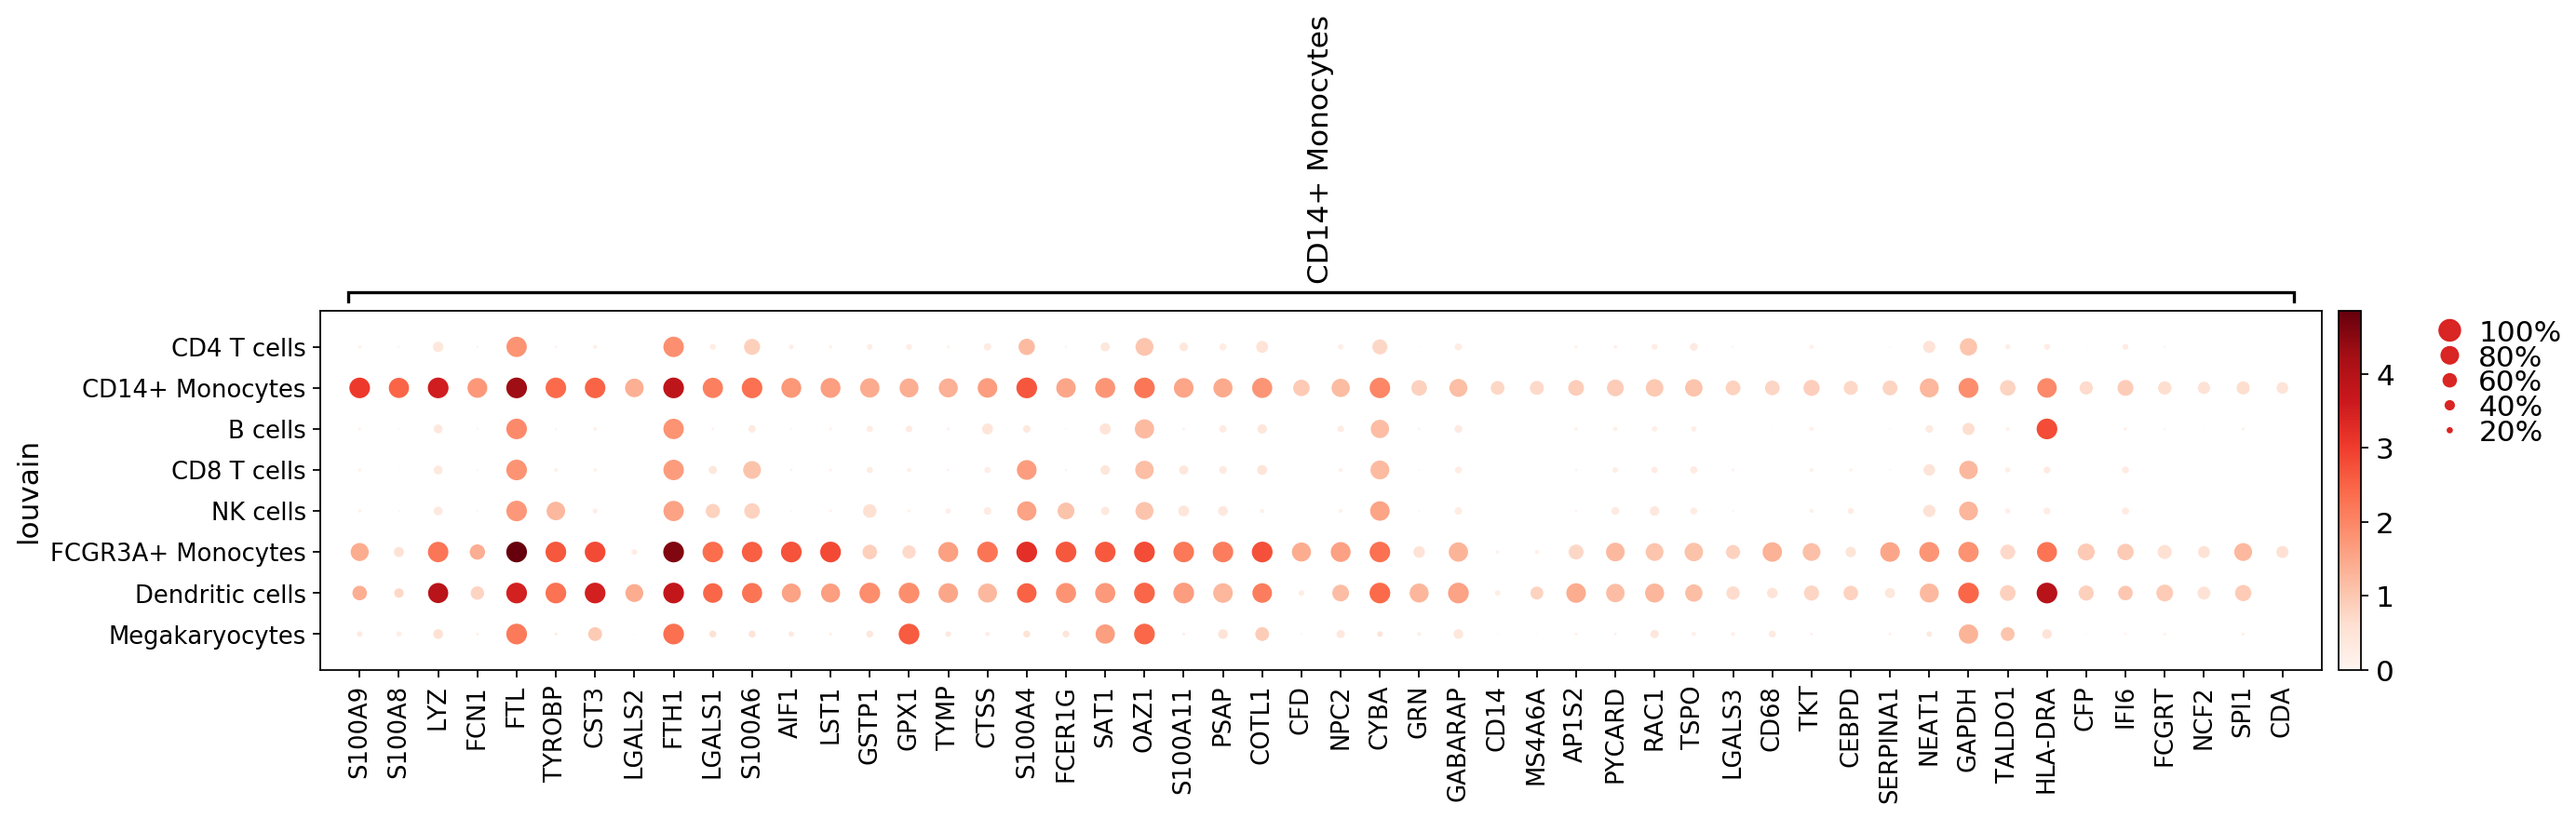

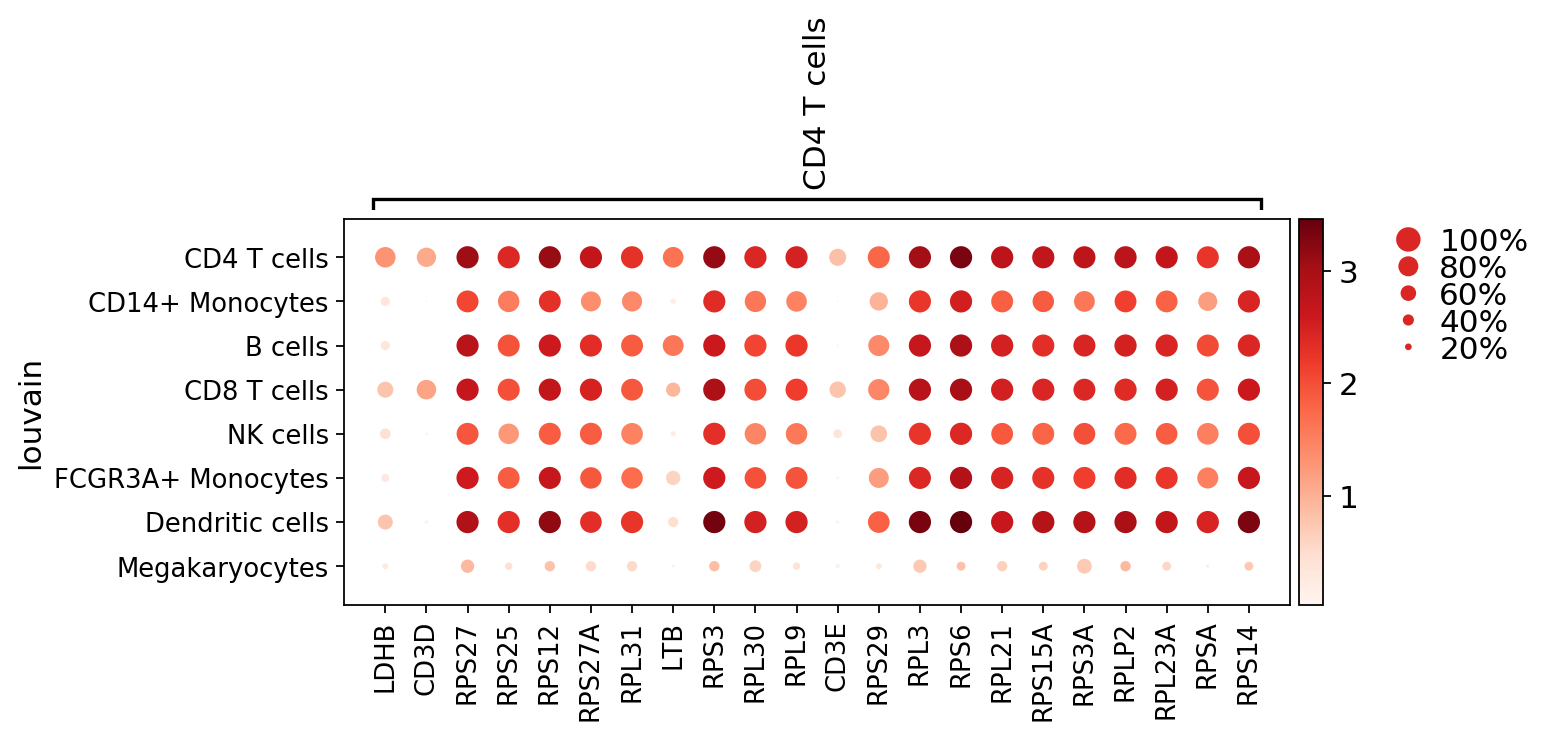

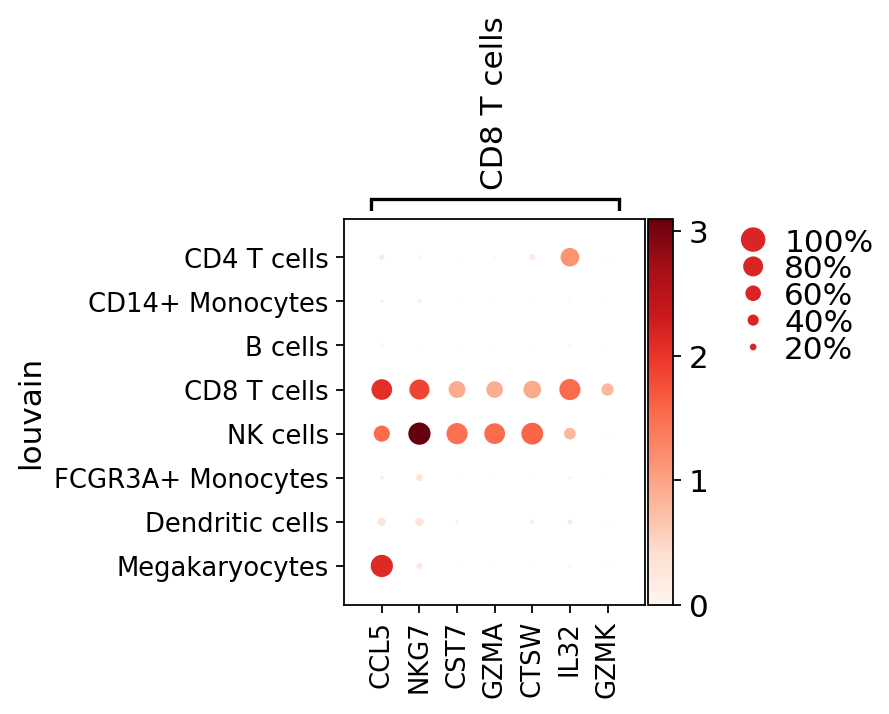

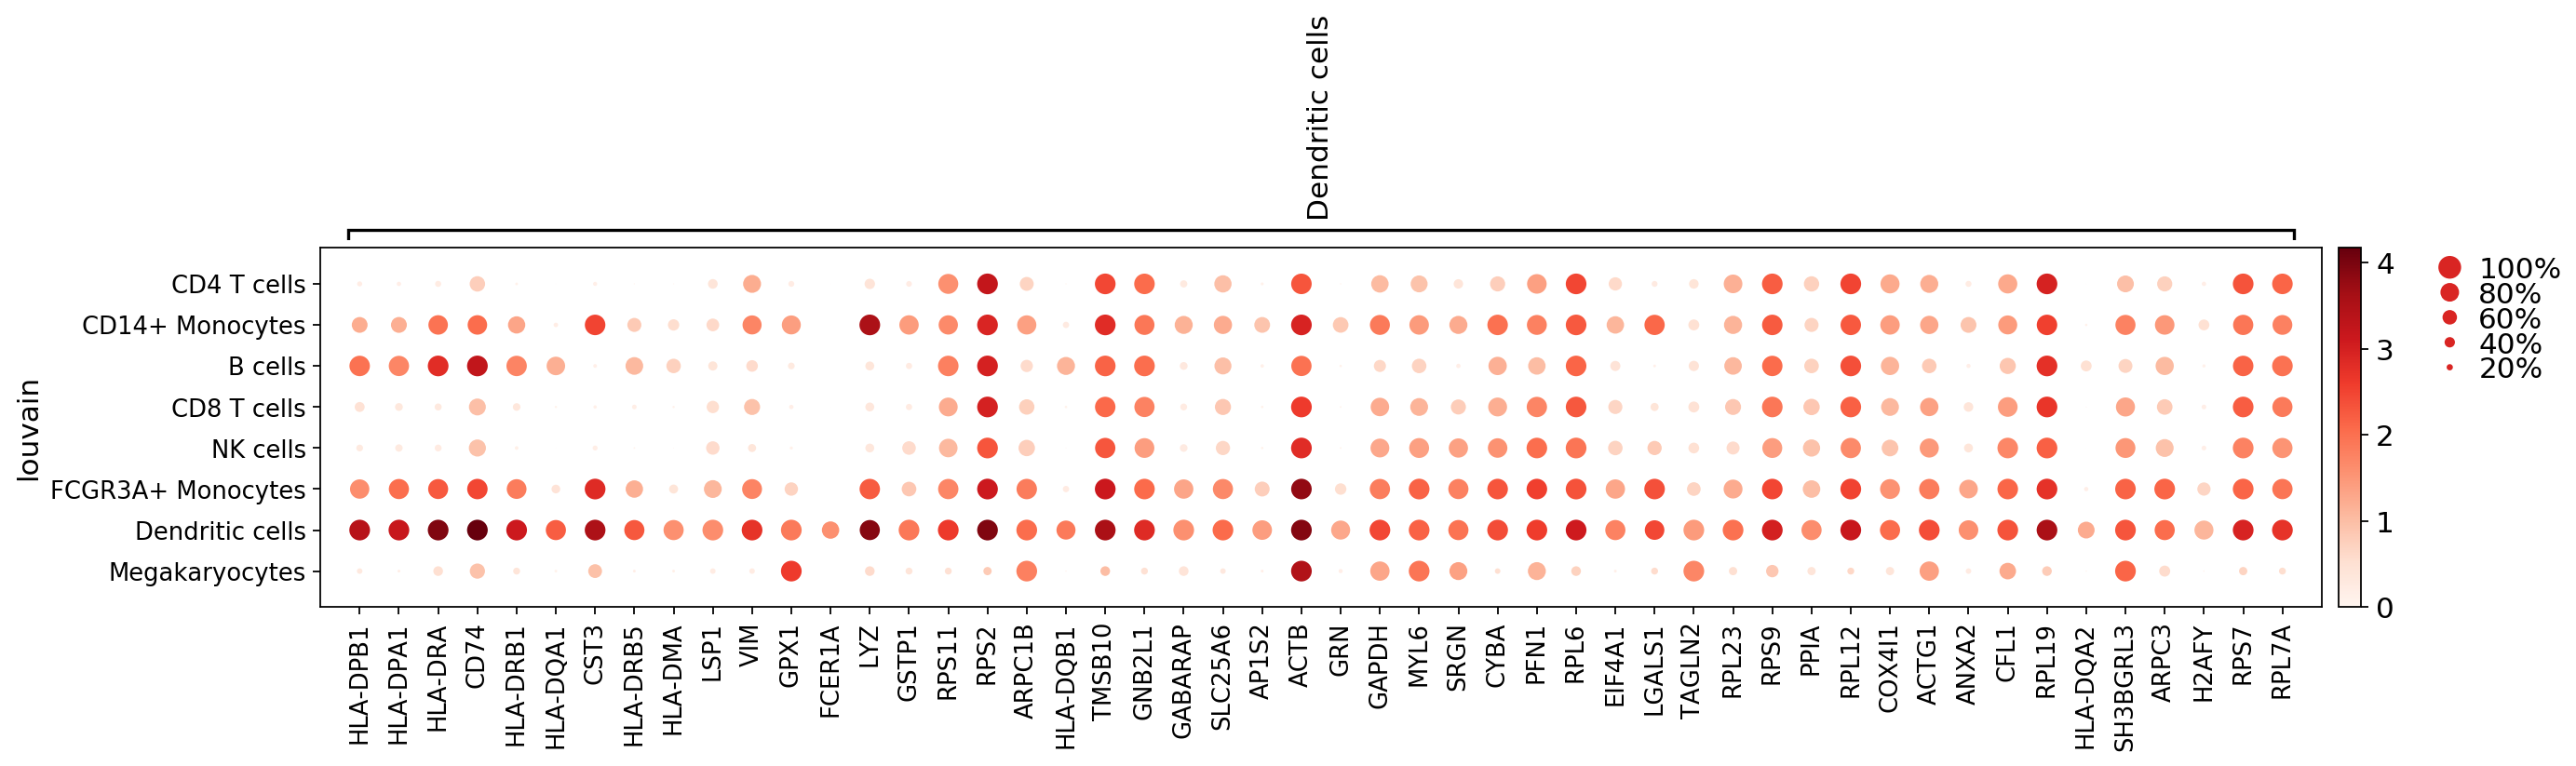

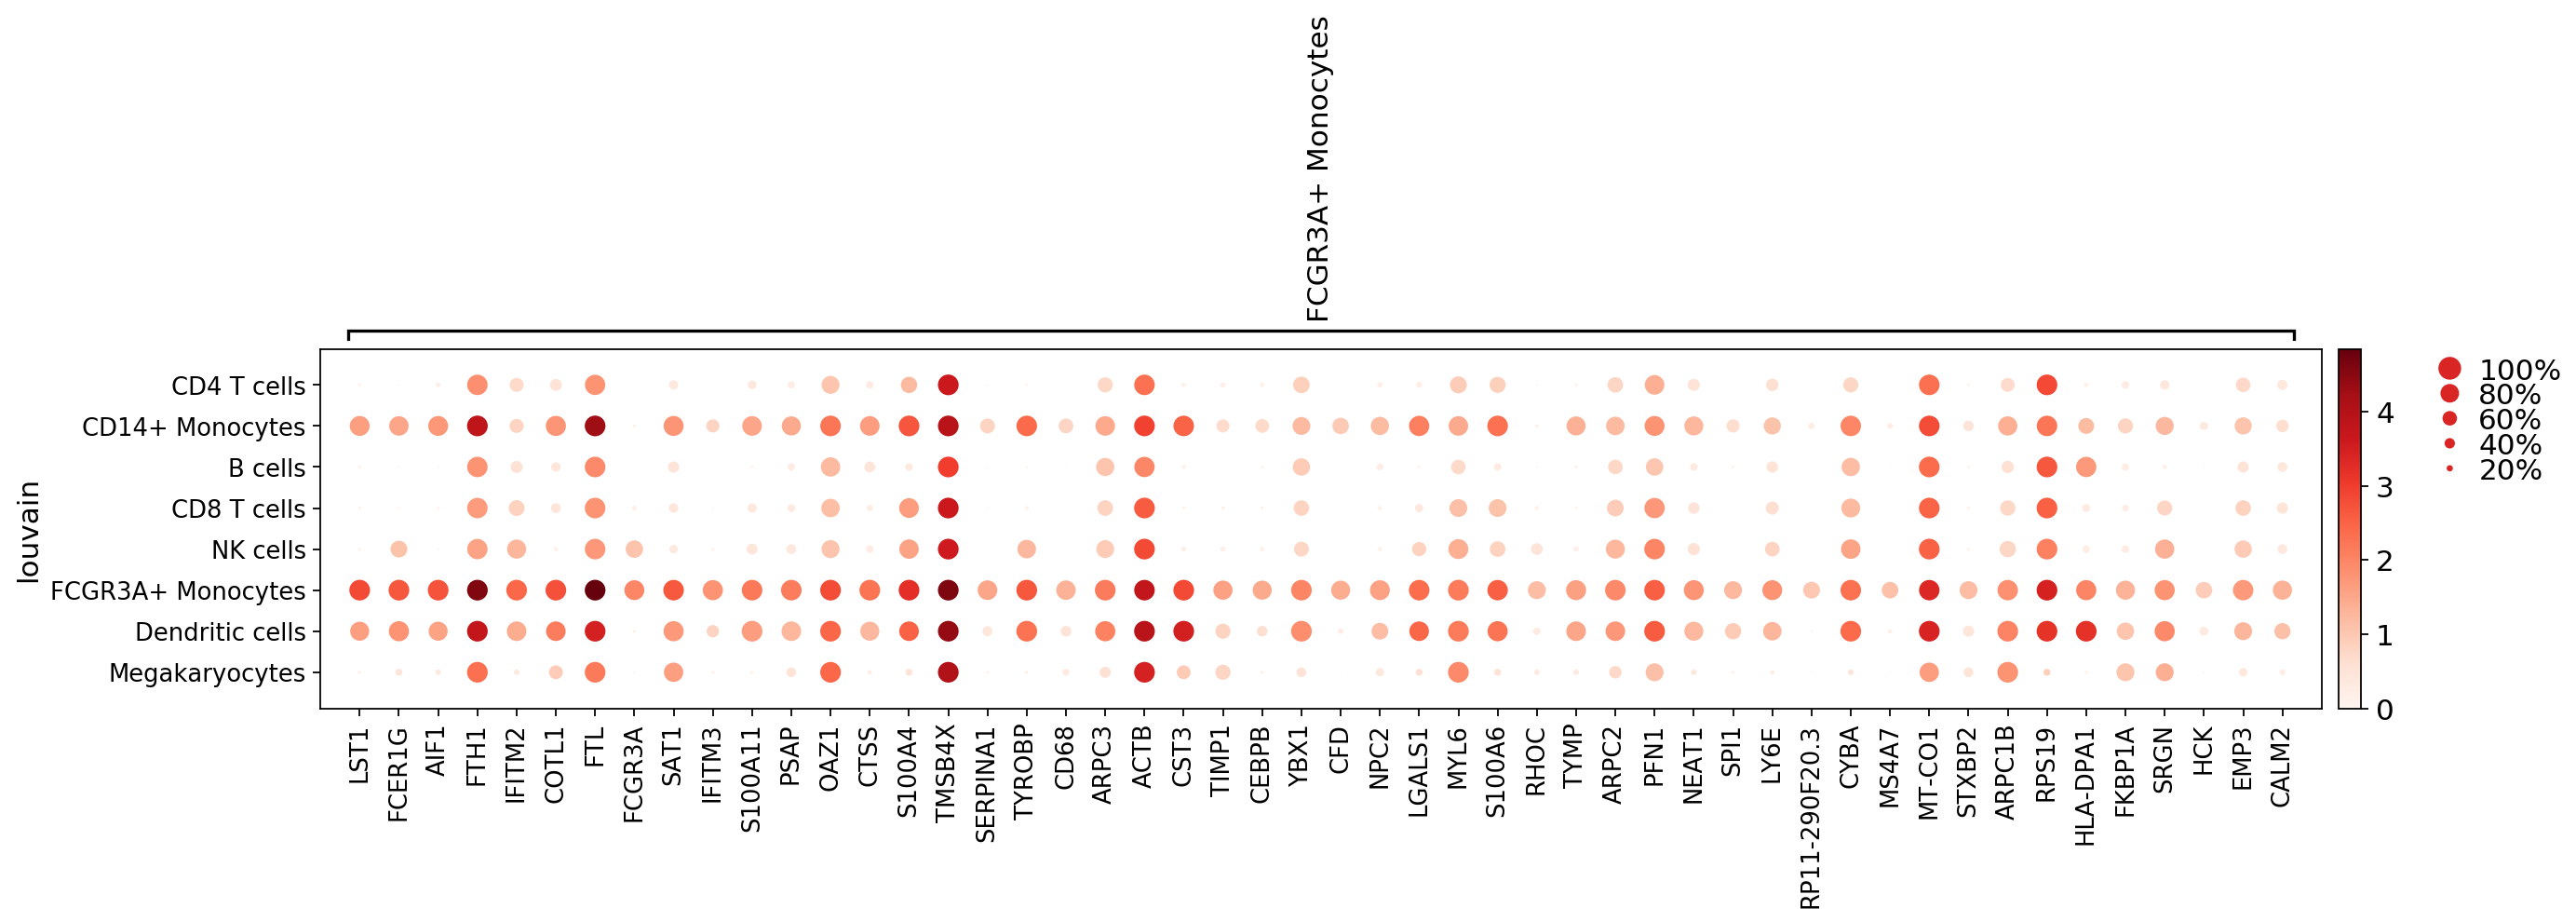

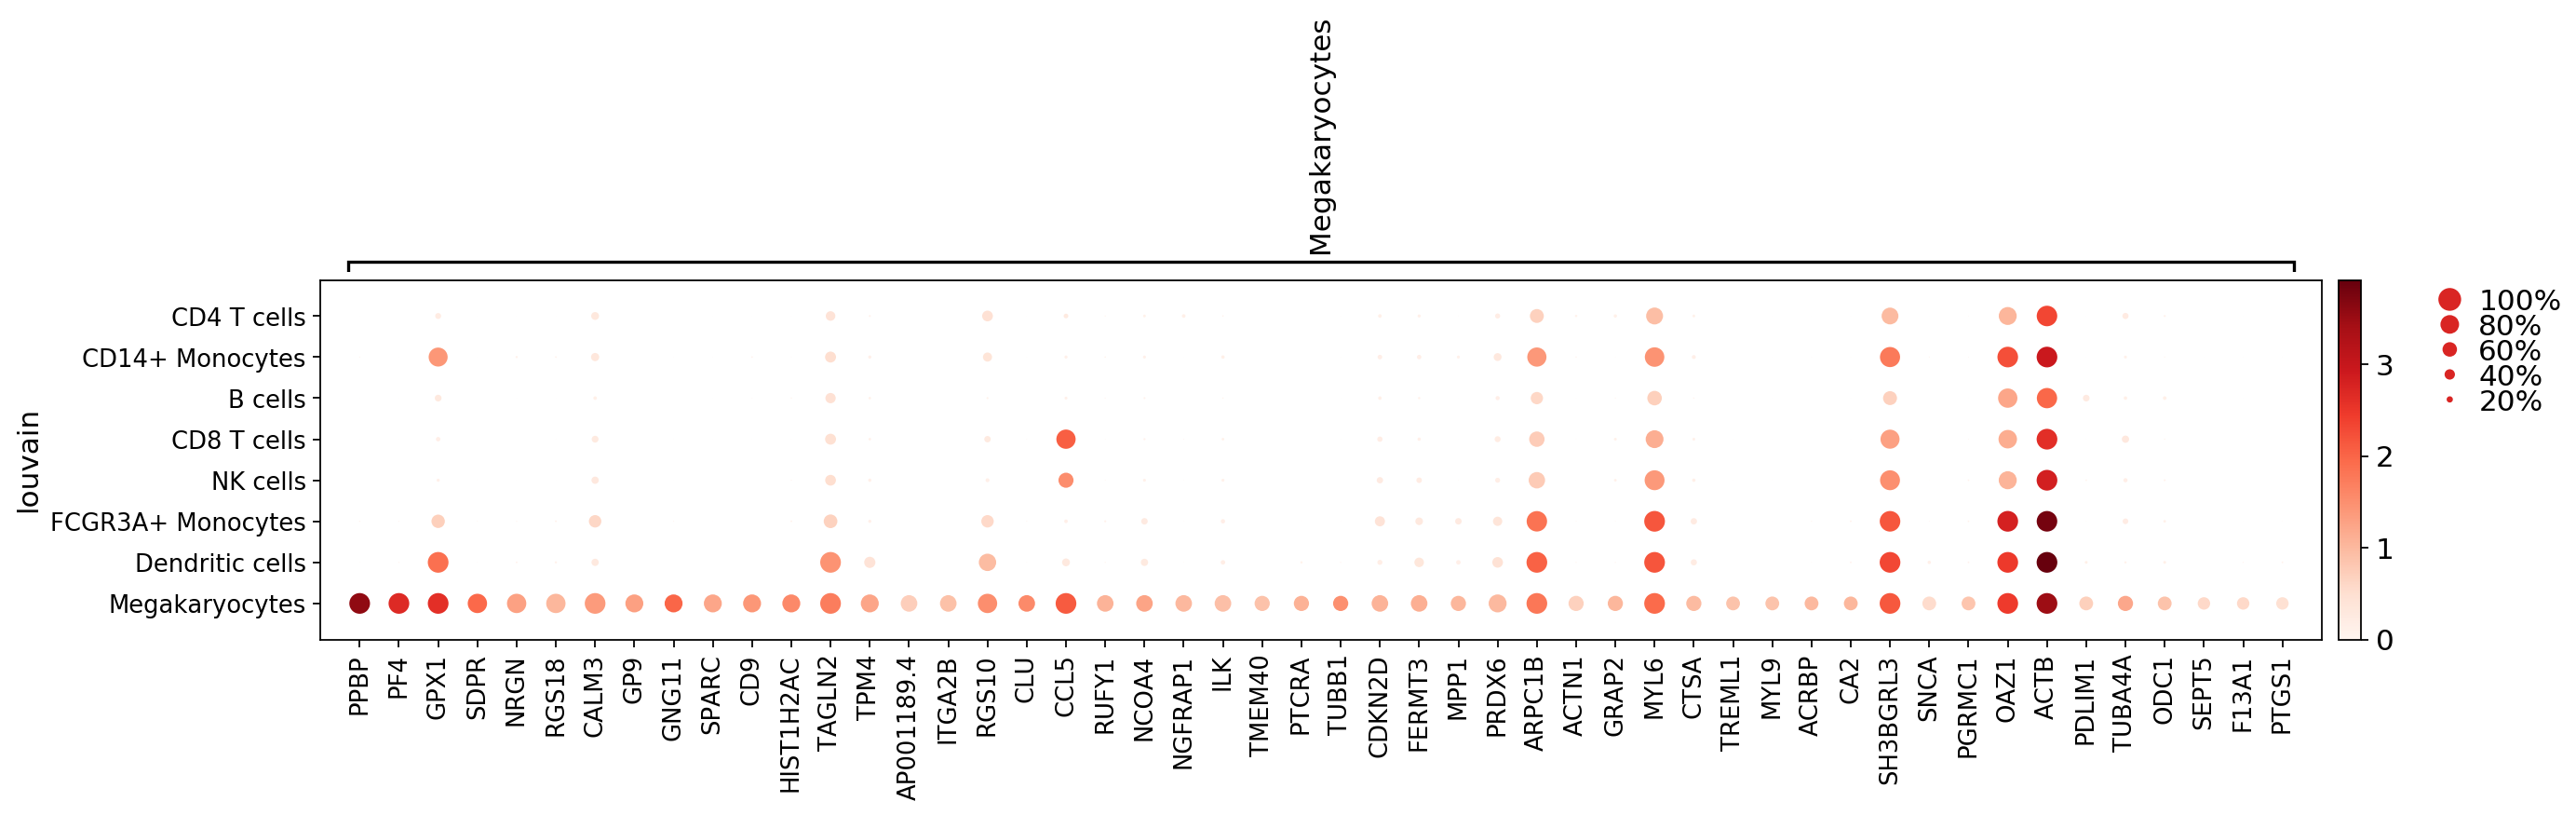

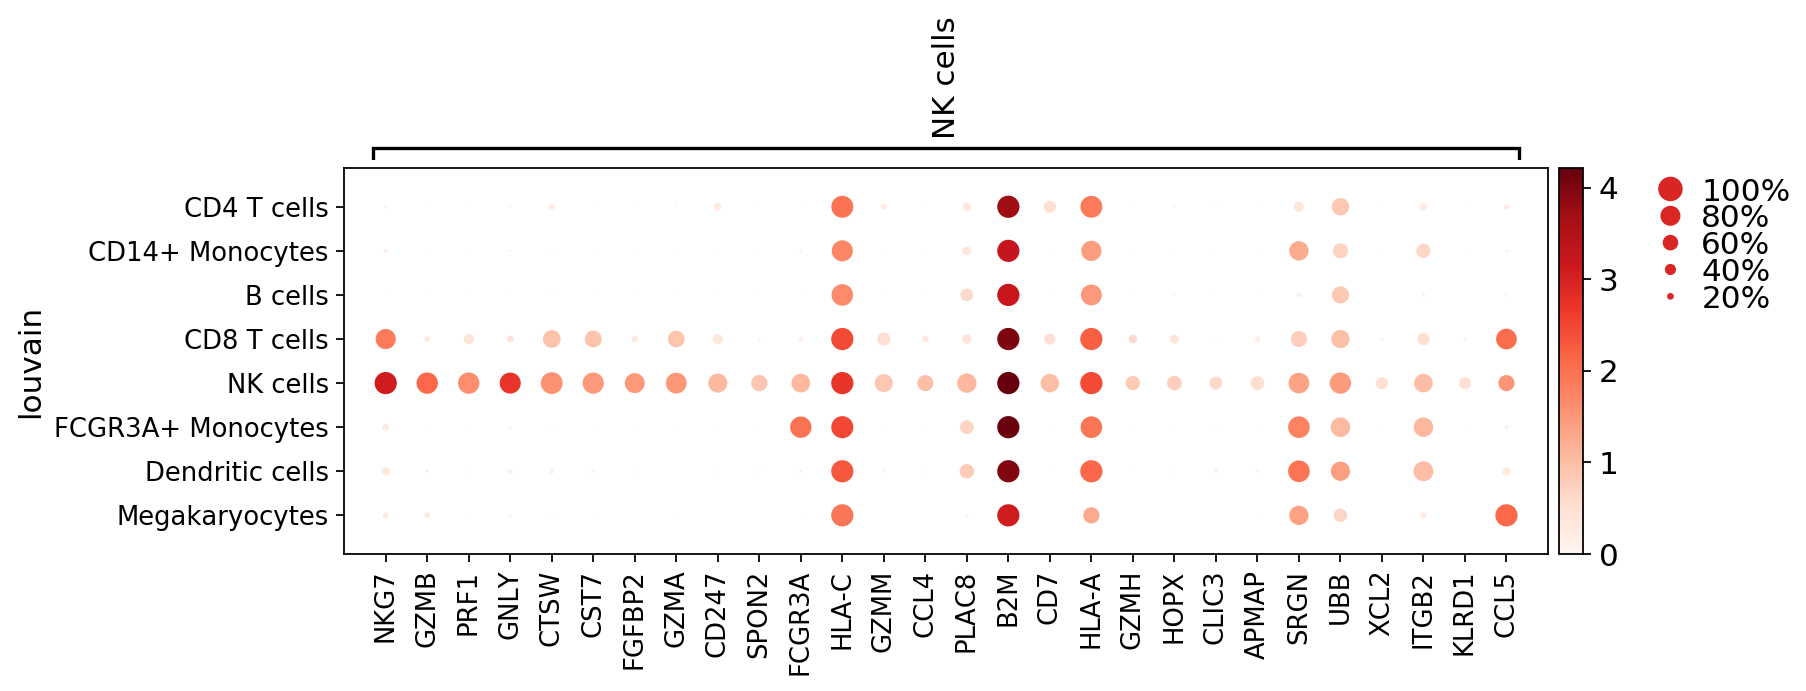

In [6]:
for clus in plot_dict.keys():
    sc.pl.dotplot(adata, {clus: plot_dict[clus][:50]}, groupby='louvain')

Write out the complete marker list. This file can be found in the `examples` folder of the GitHub repository (same place as this notebook is stored).

In [7]:
degs.to_csv('markers.csv')

Compute a traditional differential expression test with Scanpy, circumventing its top N gene heuristic and extracting the actual number of up-regulated genes for each of the clusters.

In [8]:
sc.tl.rank_genes_groups(adata, 'louvain', n_genes=100000)
result = adata.uns['rank_genes_groups']
marker_count = 0
for clus in plot_dict.keys():
    mask = (result['pvals_adj'][clus]<0.05) & (result['scores'][clus]>0)
    print('Conventional DE testing on cluster '+clus+': '+str(np.sum(mask))+' markers')
    marker_count += np.sum(mask)
print('\n'+str(marker_count)+' markers total, compared to '+str(degs.shape[0])+' from the rank-biserial correlation.')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Conventional DE testing on cluster B cells: 256 markers
Conventional DE testing on cluster CD14+ Monocytes: 1031 markers
Conventional DE testing on cluster CD4 T cells: 940 markers
Conventional DE testing on cluster CD8 T cells: 143 markers
Conventional DE testing on cluster Dendritic cells: 401 markers
Conventional DE testing on cluster FCGR3A+ Monocytes: 1240 markers
Conventional DE testing on cluster Megakaryocytes: 29 markers
Conventional DE testing on cluster NK cells: 233 markers

4273 markers total, compared to 570 from the rank-biserial correlation.


Just as a reminder, this test dataset has 2638 cells. The differences will become even more pronounced as the cell total goes up and the power of traditional statistical methods continues to increase.

In [9]:
adata.shape

(2638, 1838)

Perform a more in-depth comparison of the SCANPY and RBCDE marker identification results. Report the cell counts for each cluster, the number of markers each method identified, and the size of the intersection of the marker pools. For all non-megakaryocyte clusters, RBCDE markers are all part of the larger pool that SCANPY returns. RBCDE identifies more markers for the megakaryocytes, likely as a result of the 15-cell cluster having insignificant power in hypothesis testing. Inspecting the ranks of the 95th and 100th percentile RBCDE markers in the SCANPY list (ordered on p-value, like it would be for top N marker heuristic filtering) reveals the genes to fall near the top of the list, as expected.

In [10]:
numtemp = np.arange(len(result['names'])) + 1
summdf = pd.DataFrame(0, index=plot_dict.keys(), columns=['Cell count','SCANPY','RBCDE','Intersection','95th percentile rank','100th percentile rank'])
for clus in plot_dict.keys():
    cellcount = np.sum(adata.obs['louvain'] == clus)
    mask = (result['pvals_adj'][clus]<0.05) & (result['scores'][clus]>0)
    scmarks = np.sum(mask)
    rbcmarks = len(plot_dict[clus])
    mask = mask & ([i in plot_dict[clus] for i in result['names'][clus]])
    intersect = np.sum(mask)
    if clus=='Megakaryocytes':
        p95 = ''
        p100 = ''
    else:
        p95 = np.max(numtemp[mask][:int(round(0.95 * np.sum(mask)))])
        p100 = np.max(numtemp[mask])
    #this is useful for LaTeX table generation
    #print(' & '.join([clus,str(cellcount),str(scmarks),str(rbcmarks),str(intersect),str(p95),str(p100)])+' \\\\')
    summdf.loc[clus,'Cell count'] = cellcount
    summdf.loc[clus,'SCANPY'] = scmarks
    summdf.loc[clus,'RBCDE'] = rbcmarks
    summdf.loc[clus,'Intersection'] = intersect
    summdf.loc[clus,'95th percentile rank'] = p95
    summdf.loc[clus,'100th percentile rank'] = p100
summdf

,Cell count,SCANPY,RBCDE,Intersection,95th percentile rank,100th percentile rank
B cells,342,256,15,15,15,20
CD14+ Monocytes,480,1031,50,50,52,54
CD4 T cells,1144,940,22,22,25,26
CD8 T cells,316,143,7,7,7,7
Dendritic cells,37,401,218,218,223,274
FCGR3A+ Monocytes,150,1240,158,158,171,349
Megakaryocytes,15,29,72,29,,
NK cells,154,233,28,28,32,33
